## Imports + EDA

In [1]:
# Imports
import pandas as pd
import numpy as np
import statsmodels.api as sm
from scipy import stats
import warnings
from statsmodels.graphics.tsaplots import plot_pacf
import matplotlib.pyplot as plt

In [2]:
BASE_URL = "https://raw.githubusercontent.com/siddharthyashkukreja-cloud/QuantInvesting/35528ac1dde5d2d873e1adfd0864381326d3b768/"

# Load the data
dfPredictors = pd.read_csv(f"{BASE_URL}/predictor_data.csv")
dfPredictors.drop(columns=['Unnamed: 0'], axis=1, inplace=True) # Drop unnecessary column

variables_to_negate = ['ntis', 'tbl', 'lty', 'lagINFL']
for var in variables_to_negate:
    dfPredictors[var] = -dfPredictors[var]
dfPredictors.head()

,yyyyq,r,logDP,logDY,logEP,logDE,svar,b/m,ntis,tbl,lty,ltr,tms,dfy,dfr,lagINFL
0,19264,0.014359,-2.973012,-2.966318,-2.386837,-0.586175,0.003164,0.441476,-0.050876,-0.0307,-0.0354,0.034369,0.0047,0.0100,-0.013227,0.011299
1,19271,0.040386,-2.976535,-2.944439,-2.445079,-0.531456,0.001681,0.469765,-0.046357,-0.0320,-0.0331,0.042080,0.0011,0.0092,-0.021137,-0.011429
2,19272,0.045197,-3.007309,-2.948756,-2.531330,-0.475979,0.001819,0.452385,-0.058822,-0.0307,-0.0334,0.003423,0.0027,0.0097,0.005290,0.022599
3,19273,0.157540,-3.129097,-2.980280,-2.707759,-0.421338,0.002826,0.380586,-0.094613,-0.0268,-0.0330,0.014461,0.0062,0.0088,0.009170,-0.017341
4,19274,0.031700,-3.132667,-3.102780,-2.766942,-0.365725,0.003093,0.374689,-0.076471,-0.0317,-0.0316,0.027038,-0.0001,0.0086,-0.007817,0.017045


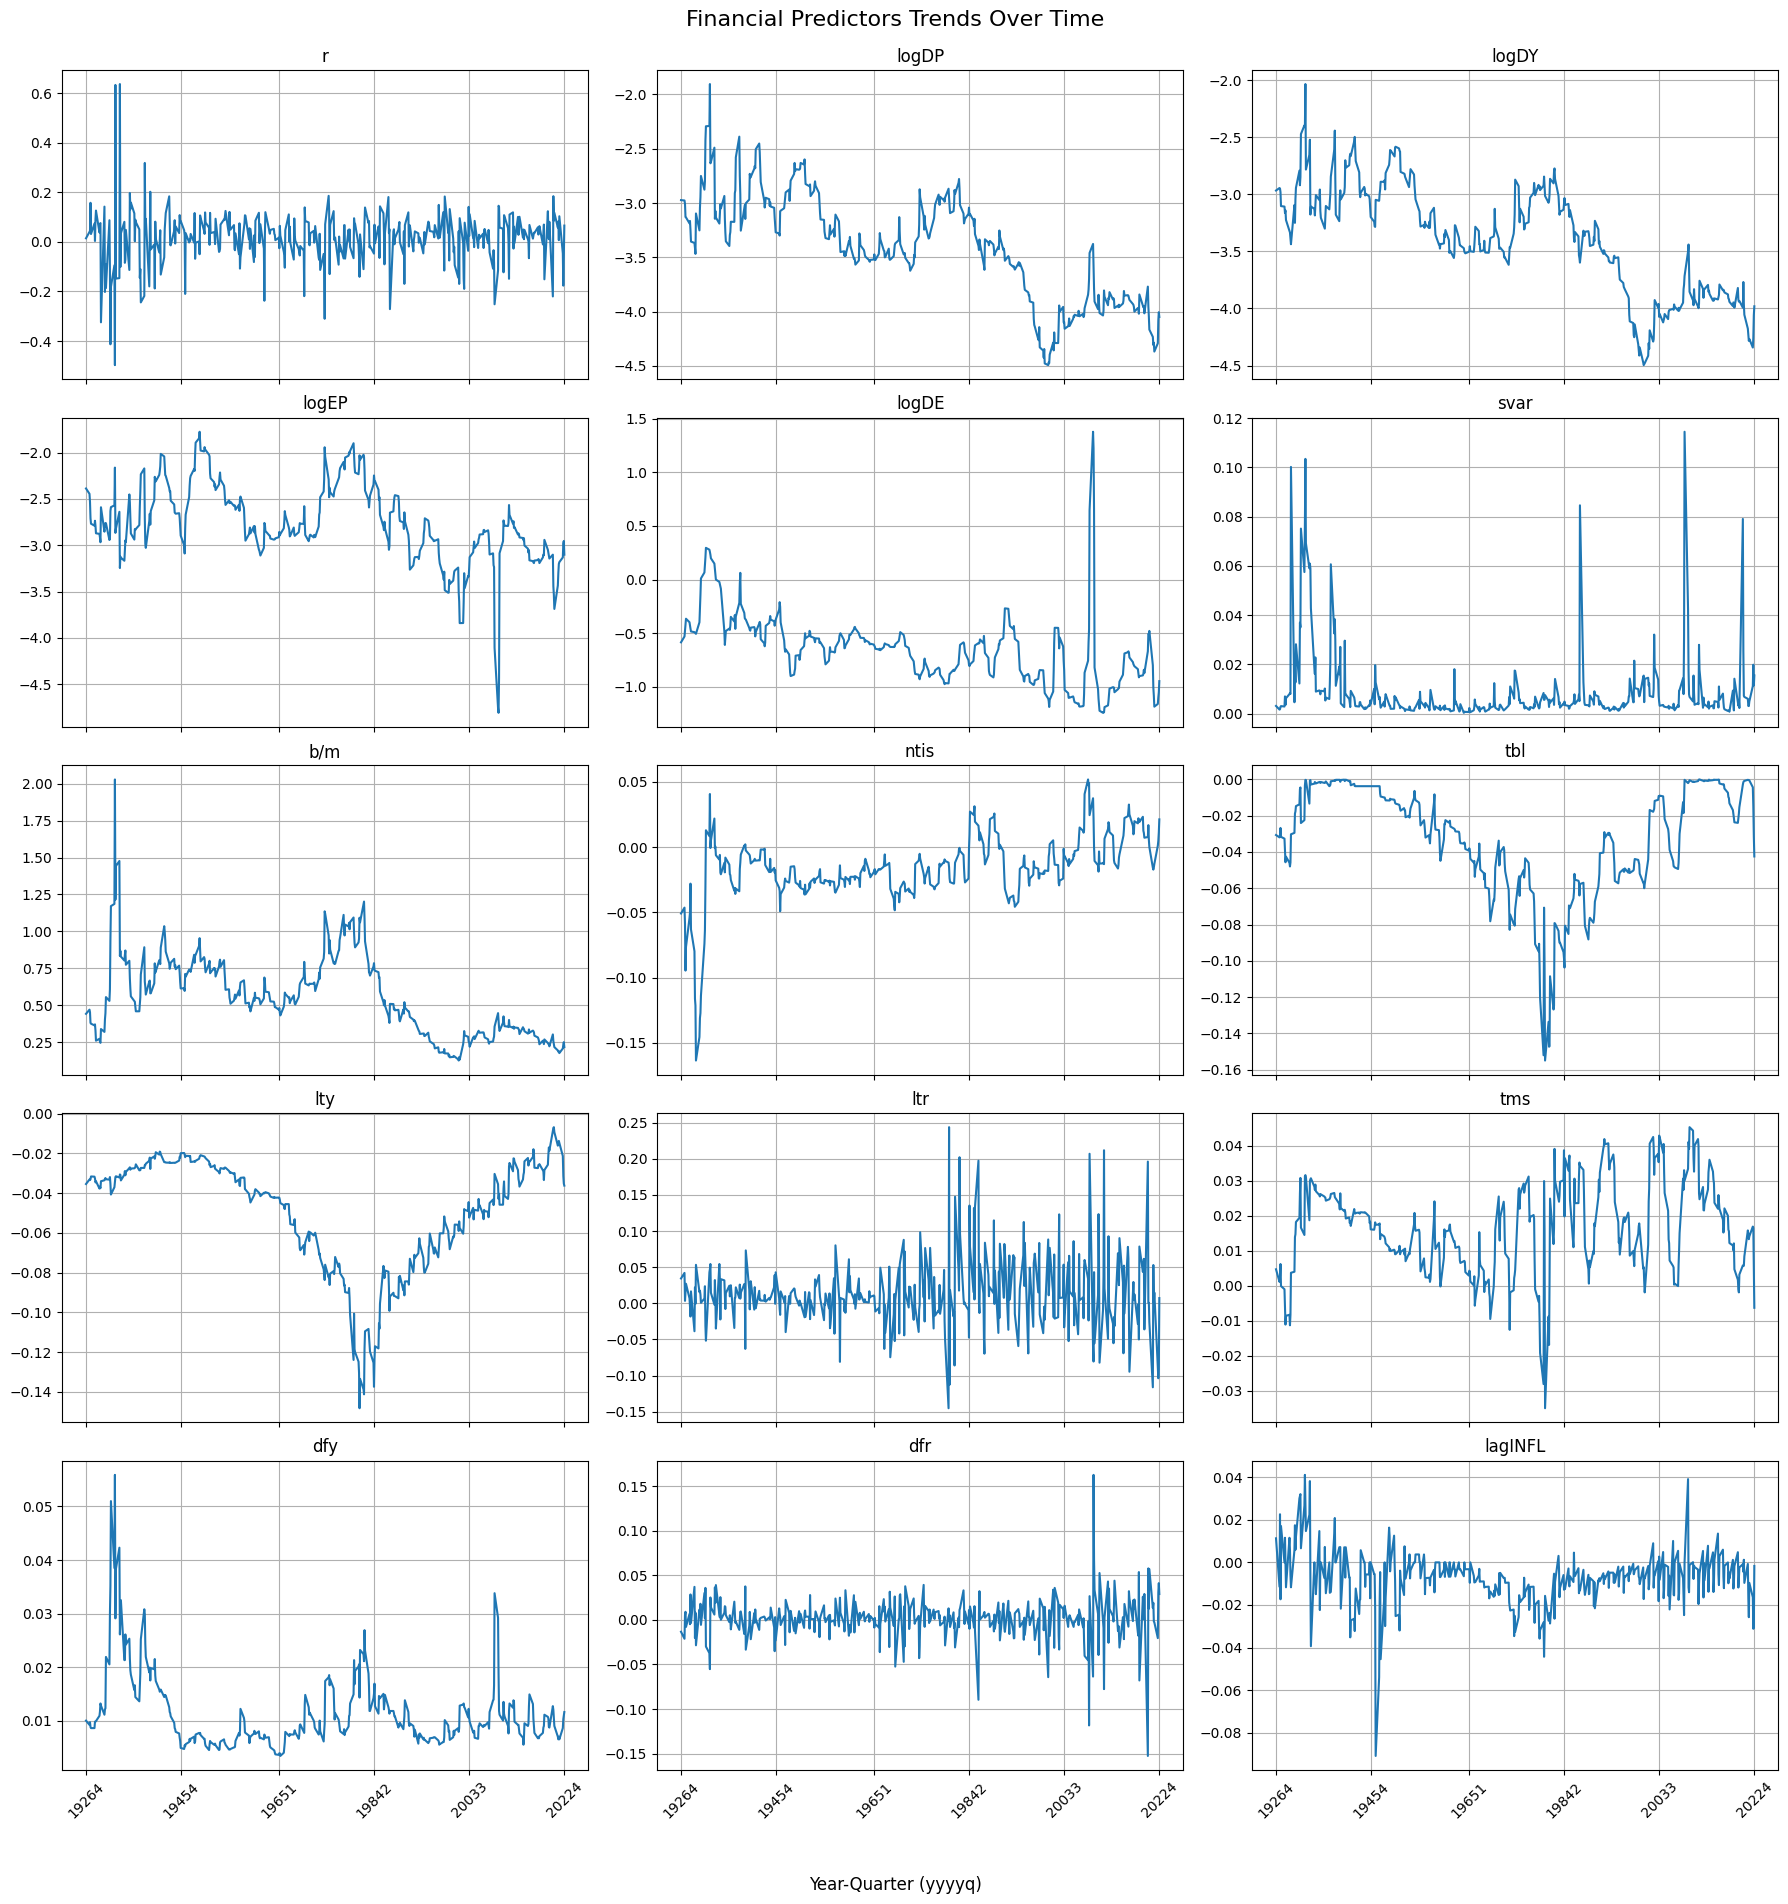

In [3]:

# Determine number of columns (excluding yyyyq which is our x-axis)
num_cols = len(dfPredictors.columns) - 1
num_rows = (num_cols + 2) // 3  # 3 plots per row, rounded up

# Create figure with subplots
fig, axes = plt.subplots(num_rows, 3, figsize=(18, num_rows * 4), sharex=True)
axes = axes.flatten()  # Flatten to make indexing easier

# Plot each column in its own subplot
col_idx = 0
for col in dfPredictors.columns:
    if col != 'yyyyq':  # Skip the x-axis column
        axes[col_idx].plot(dfPredictors['yyyyq'], dfPredictors[col])
        axes[col_idx].set_title(col)
        axes[col_idx].grid(True)
        col_idx += 1

# Hide any unused subplots
for i in range(col_idx, len(axes)):
    fig.delaxes(axes[i])

# Set major ticks at reasonable intervals for better readability
tick_indices = np.linspace(0, len(dfPredictors)-1, 6, dtype=int)
tick_values = dfPredictors.iloc[tick_indices]['yyyyq'].values

# Apply x-ticks to all subplots
for ax in axes[:col_idx]:
    ax.set_xticks(tick_values)
    ax.set_xticklabels(tick_values, rotation=45)

# Add overall title and x-axis label
plt.suptitle('Financial Predictors Trends Over Time', fontsize=16)
fig.text(0.5, 0.04, 'Year-Quarter (yyyyq)', ha='center', fontsize=12)

# Tight layout
plt.tight_layout()
plt.subplots_adjust(top=0.95, bottom=0.1)
plt.show()

Correlation Matrix:


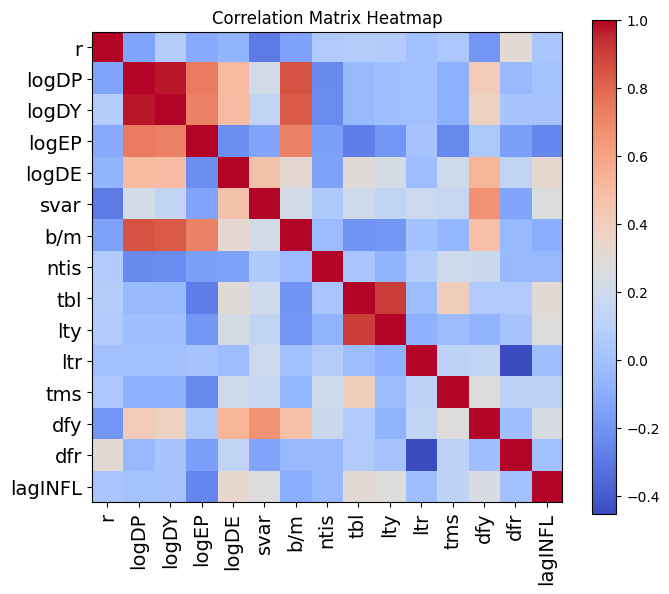

In [4]:
# Calculate the correlation matrix
correlation_matrix = dfPredictors[dfPredictors.columns[1:]].corr() # Exclude 'yyyyq' from correlation calculation

# Display the correlation matrix
print("Correlation Matrix:")
correlation_matrix

# Plot the correlation matrix as a heatmap (smaller plot, bigger tick labels)
plt.figure(figsize=(7, 6))  # Smaller size (adjust width and height as desired)
im = plt.imshow(correlation_matrix, cmap='coolwarm')
plt.colorbar(im)

# Set larger font size for axis tick labels
xtick_fontsize = 14
ytick_fontsize = 14

plt.xticks(range(len(correlation_matrix.columns)), correlation_matrix.columns, rotation=90, fontsize=xtick_fontsize)
plt.yticks(range(len(correlation_matrix.columns)), correlation_matrix.columns, fontsize=ytick_fontsize)
plt.title('Correlation Matrix Heatmap')
plt.tight_layout()
plt.show()

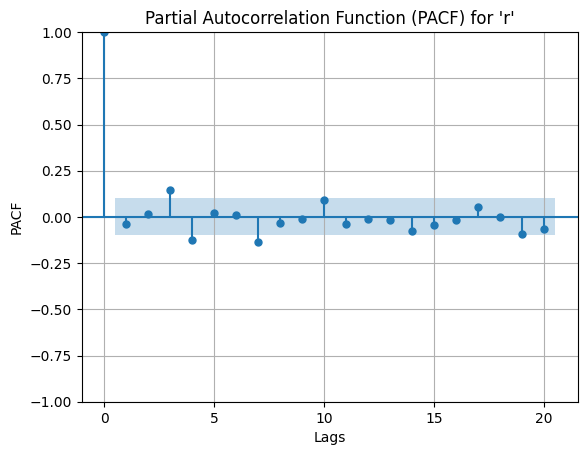

In [ ]:
# PACF test for Lag Selection

lags = 20  
plot_pacf(dfPredictors['r'], lags=lags, method='ywm', alpha=0.05)
plt.title("Partial Autocorrelation Function (PACF) for 'r'")
plt.xlabel("Lags")
plt.ylabel("PACF")
plt.grid()
plt.show()


## Question 1 simple regression for each predictor

In [3]:

def simple_regression(data, dependant_var, independent_var):
    """Performs a simple linear regression of dependant_var on independent_var.
    Args:
        pdData: The dataframe containing the data.
        strDependant_var : The name of the dependent variable column.
        strIndependent_var : The name of the independent variable column.

    Returns:
        dict: A dictionary containing regression results, coefficients, adjusted R², p-values, and robust standard errors in a list
    """
    X = data[independent_var][:-1].reset_index(drop=True) 
    y = data[dependant_var][1:].reset_index(drop=True)


    X = sm.add_constant(X)  # Adds a constant term to the predictor
    model = sm.OLS(y, X).fit(cov_type='HAC', cov_kwds={'maxlags': 4})  # Using robust standard errors


    t_stat = model.tvalues.iloc[1]  # t-statistic for the independent variable
    two_sided_p = model.pvalues[independent_var]

    if t_stat > 0:
        one_sided_p = two_sided_p / 2
    else:
        one_sided_p = 1 - (two_sided_p / 2)

    # Extract relevant information
    results = {
        "predicted_name": f"{independent_var}", # get the string name of the predictor
        "beta": model.params.iloc[1],
        "HAC t_tests": t_stat,
        "one_sided_pvalue": one_sided_p,  # One-tailed p-value
        "Adj. R²": model.rsquared_adj,
    }

    return results

# Make a list containing dictionaries of regression results for each predictor
all_results = []

for col in dfPredictors.columns[2:]:
    result = simple_regression(dfPredictors, 'r', col)
    all_results.append(result)

indiv_regression_results = pd.DataFrame(all_results)
indiv_regression_results



,predicted_name,beta,HAC t_tests,one_sided_pvalue,Adj. R²
0,logDP,0.016918,1.156706,0.123696,0.003390
1,logDY,0.015166,1.176557,0.119686,0.002087
2,logEP,0.022743,1.553994,0.060093,0.005995
3,logDE,-0.002320,-0.093785,0.537360,-0.002563
4,svar,0.135355,0.242060,0.404367,-0.002248
5,b/m,0.048654,1.681117,0.046370,0.013268
6,ntis,0.525127,1.877998,0.030191,0.013928
7,tbl,0.232338,1.492740,0.067753,0.002054
8,lty,0.204795,1.250833,0.105498,0.000432
9,ltr,0.172413,1.639831,0.050520,0.003737


##  Question 2&3 that stores values for question 4 for the holdout period and out of sample

In [ ]:
# Setup and data definitions
total_obs = len(dfPredictors)
m = 80  # Initial in-sample period
p = 40  # Holdout period for DMSPE weights
q = total_obs - m - p  # Final out-of-sample (OOS) evaluation period

predictor_variables = dfPredictors.columns[2:]
Y_full = dfPredictors['r'].values

print(f"Sample split: m={m}, p={p}, q={q}, total={total_obs}")

# Generate and store all forecasts (expanding window)
# These dictionaries will store the forecasts to be used in later questions
holdout_forecasts_dict = {}
oos_forecasts_dict = {}

print("\nGenerating individual forecasts for all predictors...")
for predictor in predictor_variables:
    holdout_forecasts = []
    oos_forecasts = []
    
    # Loop 1: Generate forecasts for the HOLDOUT period (p)
    for t in range(m, m + p):
        df_window = dfPredictors.iloc[0:t+1]
        y, X = df_window['r'], sm.add_constant(df_window[predictor].shift(1))
        model = sm.OLS(y, X, missing='drop').fit()
        forecast = model.predict([1, df_window[predictor].iloc[-1]])[0]
        holdout_forecasts.append(forecast)
        
    # Loop 2: Generate forecasts for the FINAL OOS period (q)
    for t in range(m + p, total_obs):
        df_window = dfPredictors.iloc[0:t]
        y, X = df_window['r'], sm.add_constant(df_window[predictor].shift(1))
        model = sm.OLS(y, X, missing='drop').fit()
        forecast = model.predict([1, df_window[predictor].iloc[-1]])[0]
        oos_forecasts.append(forecast)
        
    # Store the generated forecasts in the dictionaries
    holdout_forecasts_dict[predictor] = np.array(holdout_forecasts)
    oos_forecasts_dict[predictor] = np.array(oos_forecasts)

print("All individual forecasts have been generated and stored.")


### Benchmark calculation and analysis for Q2&3


# Benchmark and actuals for the final OOS period (q)
benchmark_forecasts_oos = [Y_full[0:t].mean() for t in range(m + p, total_obs)]
actual_returns_oos = Y_full[m + p : total_obs]
mspe_benchmark_oos = np.mean((actual_returns_oos - np.array(benchmark_forecasts_oos))**2)

# Q2 Results 
oos_r2_results = []
for predictor in predictor_variables:
    mspe_model = np.mean((actual_returns_oos - oos_forecasts_dict[predictor])**2)
    r2_oos = 1 - (mspe_model / mspe_benchmark_oos)
    oos_r2_results.append({'Predictor': predictor, 'R2_OOS': r2_oos})
oos_df = pd.DataFrame(oos_r2_results)
print("\n--- Question 2: Individual Predictor R2_OOS Results ---")
print(oos_df.sort_values('R2_OOS', ascending=False).to_string(index=False))

# Q3 Results
kitchen_sink_forecasts = []
for t in range(m + p, total_obs):
    df_window = dfPredictors.iloc[0:t]
    y = df_window['r']
    X = sm.add_constant(df_window[predictor_variables].shift(1))
    model = sm.OLS(y, X, missing='drop').fit()
    X_to_predict = [1.0] + df_window[predictor_variables].iloc[-1].tolist()
    forecast = model.predict(X_to_predict)[0]
    kitchen_sink_forecasts.append(forecast)
mspe_kitchen_sink = np.mean((actual_returns_oos - np.array(kitchen_sink_forecasts))**2)
r2_oos_kitchen_sink = 1 - (mspe_kitchen_sink / mspe_benchmark_oos)
print(f"\n--- Question 3: Kitchen Sink Model R2_OOS ---")
print(f"R2_OOS: {r2_oos_kitchen_sink:.6f}")

# Q4: Forecast Combinations

# Mean and Median Combinations
individual_forecasts_matrix = np.array([oos_forecasts_dict[p] for p in predictor_variables])
mean_combo_forecasts = individual_forecasts_matrix.mean(axis=0)
median_combo_forecasts = np.median(individual_forecasts_matrix, axis=0)

mspe_mean_combo = np.mean((actual_returns_oos - mean_combo_forecasts)**2)
r2_oos_mean_combo = 1 - (mspe_mean_combo / mspe_benchmark_oos)

mspe_median_combo = np.mean((actual_returns_oos - median_combo_forecasts)**2)
r2_oos_median_combo = 1 - (mspe_median_combo / mspe_benchmark_oos)

print(f"Mean Combination R2_OOS:     {r2_oos_mean_combo:.6f}")
print(f"Median Combination R2_OOS:   {r2_oos_median_combo:.6f}")

# DMSPE Combination 
def get_dmspe_forecasts(theta):
    weights = []
    actual_returns_holdout = Y_full[m : m + p]
    
    for predictor in predictor_variables:
        forecasts_holdout = holdout_forecasts_dict[predictor]
        errors_sq = (actual_returns_holdout - forecasts_holdout)**2
        phi = sum([(theta**(p - 1 - s)) * errors_sq[s] for s in range(p)])
        weights.append(1 / (phi + 1e-8))
        
    weights = np.array(weights) / np.sum(np.array(weights))
    dmspe_combo_forecasts = np.dot(weights, individual_forecasts_matrix)
    return dmspe_combo_forecasts

for theta_val in [0.9, 1.0]:
    dmspe_forecasts = get_dmspe_forecasts(theta=theta_val)
    mspe_dmspe = np.mean((actual_returns_oos - dmspe_forecasts)**2)
    r2_oos_dmspe = 1 - (mspe_dmspe / mspe_benchmark_oos)
    print(f"DMSPE (theta={theta_val}) R2_OOS:    {r2_oos_dmspe:.6f}")

Sample split: m=80, p=40, q=265, total=385

Generating individual forecasts for all predictors...
All individual forecasts have been generated and stored.

--- Question 2: Individual Predictor R2_OOS Results ---
Predictor    R2_OOS
  lagINFL  0.004550
      ltr  0.002835
      dfy  0.001194
      tbl -0.001966
     svar -0.003494
      tms -0.003943
    logDY -0.006888
    logDP -0.016713
      lty -0.025762
     ntis -0.033157
    logDE -0.042236
      dfr -0.046022
    logEP -0.063330
      b/m -0.072744

--- Question 3: Kitchen Sink Model R2_OOS ---
R2_OOS: -0.268831
Mean Combination R2_OOS:     0.005131
Median Combination R2_OOS:   0.005771
DMSPE (theta=0.9) R2_OOS:    0.005118
DMSPE (theta=1.0) R2_OOS:    0.005364


## Question 4



--- Forecast Combination R2_OOS Results ---
Mean Combination:     0.005131
Median Combination:   0.005771
DMSPE (theta=0.9):    0.005373
DMSPE (theta=1.0):    0.005564
DMSPE (theta=0.5):    0.006892
DMSPE (theta=0.2):    0.006853
DMSPE (theta=0.1):    0.005861
DMSPE (theta=0.01):   -0.002795


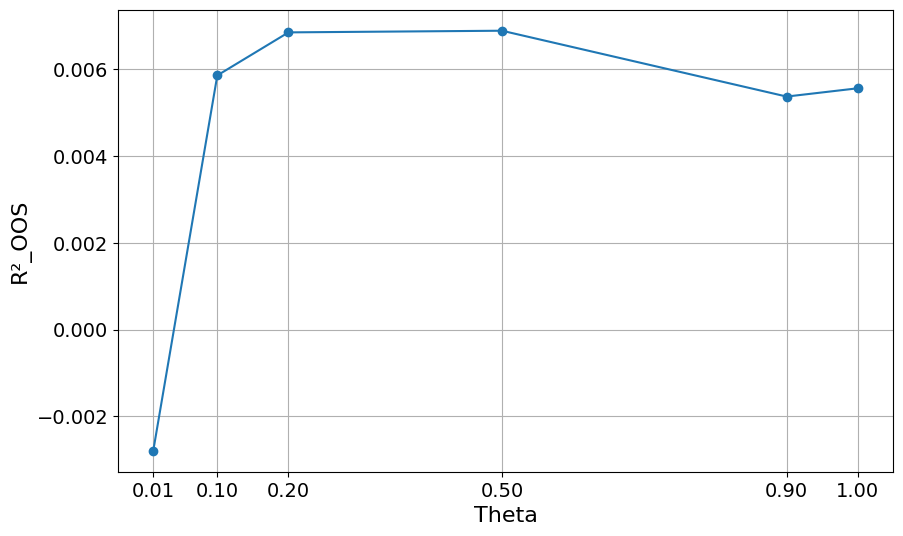

In [ ]:
# Dictionaries: holdout_forecasts_dict, oos_forecasts_dict
# Numpy Arrays: actual_returns_oos, mspe_benchmark_oos

# 1. Mean and Median Combinations
# Create a matrix of individual forecasts (models x time)
individual_forecasts_matrix = np.array([oos_forecasts_dict[p] for p in predictor_variables])

# Calculate mean and median across models (axis=0) for each time period
mean_combo_forecasts = individual_forecasts_matrix.mean(axis=0)
median_combo_forecasts = np.median(individual_forecasts_matrix, axis=0)

# Evaluate Mean Combination
mspe_mean_combo = np.mean((actual_returns_oos - mean_combo_forecasts)**2)
r2_oos_mean_combo = 1 - (mspe_mean_combo / mspe_benchmark_oos)

# Evaluate Median Combination
mspe_median_combo = np.mean((actual_returns_oos - median_combo_forecasts)**2)
r2_oos_median_combo = 1 - (mspe_median_combo / mspe_benchmark_oos)

# 2. DMSPE Combination
def calculate_dmspe_forecasts(theta):
    """Calculates DMSPE weights from holdout period and applies them to OOS forecasts."""
    phi_weights = []
    actual_returns_holdout = Y_full[m + 1 : m + p + 1]
    
    # Step 1: Calculate weights based on holdout period performance
    for predictor in predictor_variables:
        forecasts_holdout = holdout_forecasts_dict[predictor]
        errors_sq = (actual_returns_holdout - forecasts_holdout)**2
        
        # Calculate discounted sum of squared errors (phi)
        phi = sum([(theta**(p - 1 - s)) * errors_sq[s] for s in range(p)])
        phi_weights.append(1 / (phi + 1e-8)) # Add small constant for stability
        
    # Normalize weights to sum to 1
    phi_weights = np.array(phi_weights) / np.sum(np.array(phi_weights))
    
    # Step 2: Apply fixed weights to the out-of-sample forecasts
    dmspe_combo_forecasts = np.dot(phi_weights, individual_forecasts_matrix)
    
    return dmspe_combo_forecasts

# Calculate DMSPE for theta = 0.9
dmspe_forecasts_09 = calculate_dmspe_forecasts(theta=0.9)
mspe_dmspe_09 = np.mean((actual_returns_oos - dmspe_forecasts_09)**2)
r2_oos_dmspe_09 = 1 - (mspe_dmspe_09 / mspe_benchmark_oos)

# Calculate DMSPE for theta = 1.0
dmspe_forecasts_10 = calculate_dmspe_forecasts(theta=1.0)
mspe_dmspe_10 = np.mean((actual_returns_oos - dmspe_forecasts_10)**2)
r2_oos_dmspe_10 = 1 - (mspe_dmspe_10 / mspe_benchmark_oos)

## Further DMSPE calculations in order to grasp the effect of theta on R²_OOS
# Calculate DMSPE for theta = 0.5
dmspe_forecasts_05 = calculate_dmspe_forecasts(theta=0.5)
mspe_dmspe_05 = np.mean((actual_returns_oos - dmspe_forecasts_05)**2)
r2_oos_dmspe_05 = 1 - (mspe_dmspe_05 / mspe_benchmark_oos)

# Calculate DMSPE for theta = 0.2
dmspe_forecasts_02 = calculate_dmspe_forecasts(theta=0.2)
mspe_dmspe_02 = np.mean((actual_returns_oos - dmspe_forecasts_02)**2)
r2_oos_dmspe_02 = 1 - (mspe_dmspe_02 / mspe_benchmark_oos)

# Calculate DMSPE for theta = 0.1
dmspe_forecasts_01 = calculate_dmspe_forecasts(theta=0.1)
mspe_dmspe_01 = np.mean((actual_returns_oos - dmspe_forecasts_01)**2)
r2_oos_dmspe_01 = 1 - (mspe_dmspe_01 / mspe_benchmark_oos)

# Calculate DMSPE for theta = 0.01
dmspe_forecasts_001 = calculate_dmspe_forecasts(theta=0.01)
mspe_dmspe_001 = np.mean((actual_returns_oos - dmspe_forecasts_001)**2)
r2_oos_dmspe_001 = 1 - (mspe_dmspe_001 / mspe_benchmark_oos)

# 3. Display Final Results for Question 4
print("\n--- Forecast Combination R2_OOS Results ---")
print(f"Mean Combination:     {r2_oos_mean_combo:.6f}")
print(f"Median Combination:   {r2_oos_median_combo:.6f}")
print(f"DMSPE (theta=0.9):    {r2_oos_dmspe_09:.6f}")
print(f"DMSPE (theta=1.0):    {r2_oos_dmspe_10:.6f}")
print(f"DMSPE (theta=0.5):    {r2_oos_dmspe_05:.6f}")
print(f"DMSPE (theta=0.2):    {r2_oos_dmspe_02:.6f}")
print(f"DMSPE (theta=0.1):    {r2_oos_dmspe_01:.6f}")
print(f"DMSPE (theta=0.01):   {r2_oos_dmspe_001:.6f}")

# Plot R²_OOS results
xtick_fontsize = 14
label_fontsize = 16  

theta_values = [0.01, 0.1, 0.2, 0.5, 0.9, 1.0]
r2_oos_dmspe_values = [r2_oos_dmspe_001, r2_oos_dmspe_01, r2_oos_dmspe_02, r2_oos_dmspe_05, r2_oos_dmspe_09, r2_oos_dmspe_10]

plt.figure(figsize=(10, 6))
plt.plot(theta_values, r2_oos_dmspe_values, marker='o')

plt.xlabel('Theta', fontsize=label_fontsize)
plt.ylabel('R²_OOS', fontsize=label_fontsize)

plt.grid()
plt.xticks(theta_values, fontsize=xtick_fontsize)
plt.yticks(fontsize=xtick_fontsize)

plt.show()


## Question 5